In [ ]:
#Save climatology, std dev, weight anomalies, eofs, physical, eigenvector,

In [1]:
import netCDF4 as nc
from netCDF4 import Dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, interactive, fixed, interact_manual
from ipywidgets.embed import embed_minimal_html
import ipywidgets as widgets
import os
os.environ["PROJ_LIB"] = "C:\\Utilities\\Python\\Anaconda\\Library\\share"; #fixr
from mpl_toolkits.basemap import Basemap

# Downloading Data

In [2]:
os.chdir('C:/Users/tbui0/OneDrive/Desktop/EOFs for all Months/January/')

In [3]:
#for year in years:
#   url = 'https://downloads.psl.noaa.gov/Datasets/godas/pottmp.'+str(year)+'.nc'
#    r = requests.get(url, allow_redirects = True)
#    open('pottmp.'+str(year)+'.nc', 'wb').write(r.content)

# Compiling and Reformatting Datasets

In [4]:
file = 'C:/Users/tbui0/Downloads/air.mon.meanv3.nc'
AirData = nc.Dataset(file)


In [5]:
AirData

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4_CLASSIC data model, file format HDF5):
    Conventions: CF-1.2
    title: Monthly NOAA/CIRES/DOE 20th Century Reanalysis V3
    comments: Data are from 
NOAA/CIRES/DOE 20th Century Reanalysis version 3
(8x/day).  It consists of most variables interpolated to
pressure surfaces from model hybrid (sigma/pressure) surfaces.
    platform: Model
    standard_name_vocabulary: NetCDF Climate and Forecast (CF) Metadata Convention
    license: These data are available free of charge under the PSD data policy
    spatial_resolution: 1.0 degree
    version: 3si
    history: created 2018/11 by Hoop (chunked, deflated non-packed netCDF4-Classic)
esrl.psd.data@noaa.gov
    source: 20CRv3si 2018, Ensemble Kalman Filter, ocean (specified): SODAsi.3; 
atmosphere: NCEP GFS v14.0.1; 
sea ice (specified): HadISST2.3 
(years prior to 1850 use climatology of 1860-1891); 
land: Noah 4 layer version 2
    name_of_model_used: ensda_v451
    creation_date: 2

In [5]:
years = np.arange(1980,2016)
WaterData = []
for year in years:
    file = 'C:/Users/tbui0/Yearly Pottmps/pottmp.'+str(year)+'.nc'
    WaterData.append(nc.Dataset(file))


In [6]:
lats = AirData.variables['lat'][:]
lons = AirData.variables['lon'][:]
time = AirData.variables['time'][:]
air = AirData.variables['air'][(1980-1836)*12::12]
levels = AirData.variables['level'][:]

In [12]:
air.shape

(36, 28, 181, 360)

In [15]:
len(WaterData)

36

In [6]:
CombinedData = []
for g in range(0, len(WaterData)):
    YEARLY_AIR = np.array(air[g].flatten()).tolist()
    ANNUAL_WATER = WaterData[g].variables['pottmp'][0]
    YEARLY_WATER = np.array(ANNUAL_WATER[0].flatten()).tolist()
    CombinedData.append(YEARLY_AIR + YEARLY_WATER)
CombinedData = np.array(CombinedData).T
CombinedData.shape

(1974960, 36)

In [26]:
np.nanmin(CombinedData[air[0].size:])

268.3369140625

In [25]:
#Replaces with Nan because of how GODAS data is formatted
for i in range(air[0].size, CombinedData.shape[0]):
    for j in range(0, CombinedData.shape[1]):
        if (CombinedData[i,j] < 0):
            CombinedData[i,j] = np.nan

# Basic Computations (anomalies, climatology, Standard Deviation, etc)

In [27]:
import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=RuntimeWarning)
    clim = np.nanmean(CombinedData, axis=1)
    sdev = np.nanstd(CombinedData, axis = 1)

In [28]:
clim = np.reshape(clim, (clim.size, 1))
sdev = np.reshape(sdev, (sdev.size,1))

In [3]:
JanClim = np.load('January Climatology.npy')
JanStDev = np.load('January St Dev.npy')
np.save('C:/Users/tbui0/OneDrive/Desktop/EOFs for all Months/January/JanClim.npy',JanClim)
np.save('C:/Users/tbui0/OneDrive/Desktop/EOFs for all Months/January/JanSDEV.npy',JanStDev)

In [30]:
np.save('January Climatology.npy', clim)
np.save('January St Dev.npy', sdev)

In [7]:
waterlons = np.array(WaterData[0].variables['lon'][:])
waterlats = np.array(WaterData[0].variables['lat'][:])
xxwater, yywater = np.meshgrid(waterlons, waterlats)
xxair, yyair = np.meshgrid(lons, lats)
depths =WaterData[0].variables['level'][:]
depths.size

40

In [32]:
#standardized anomalies
np.seterr(divide='ignore', invalid='ignore')
stnd_anom = (CombinedData - clim)/ sdev

# Weight Computations

$$ \sqrt{c_p \rho \Delta d_{ij}  \cos{\phi}\Delta \theta \Delta \phi }$$

In [33]:
lats4air = np.array(yyair).flatten().tolist()
lats4water = np.array(yywater).flatten().tolist()

In [40]:
lats4weighing = []
for i in range(levels.size):
    lats4weighing += lats4air
lats4weighing += lats4water

In [41]:
lats4weighing = np.array(lats4weighing)
lats4weighing.shape

(1974960,)

In [42]:
#cos phi
weightedA = np.sqrt(np.cos(lats4weighing*np.pi/180))
weightedA = np.reshape(weightedA, (weightedA.size, 1))
weightedA.shape

(1974960, 1)

In [43]:
weightedAnom = stnd_anom * weightedA

# Airheight

$ P = P_0 e^{\frac{-gM(h-h_0)}{RT}}$

In [44]:
airclim =clim[0:air[0].size]

In [45]:
p = 101325e-2
r = 8.31432
m = 0.0289644
g = 9.8

In [48]:
airheights = []
for i in range(0, 360*181):
    airheights.append(r*airclim[i]/(-g*m)*np.log(levels[int(i/(181*360))]/p))
for i in range(181*360, airclim.size):
    airheights.append(r*airclim[i]/(-g*m)*np.log(levels[int(i/(181*360))]/levels[int(i/(181*360))-1]) +airheights[i-(181*360)])

In [49]:
airheights = np.array(airheights)
airheights

array([[  102.83877947],
       [  102.83877947],
       [  102.83877947],
       ...,
       [46003.68212965],
       [46003.68212965],
       [46003.68212965]])

In [50]:
airheights = np.reshape(airheights, (airheights.size, 1))

In [72]:
np.min(airheights)

92.40881181775232

In [51]:
np.save('January airheights.npy', airheights)

Thickness 
$$ \Delta d_{ij}$$

In [56]:
waterthickness = [5]


In [74]:
thickness = np.empty([stnd_anom.shape[0], 1])
thickness[0:181*360] = airheights[0:181*360]
for i in range(181*360, air[0].size):
    thickness[i] = airheights[i] - airheights[i-181*360]
for j in range(air[0].size, stnd_anom.shape[0]):
    thickness[j] = waterthickness[int((j-air[0].size)/(360*418))]

In [75]:
thickness.shape

(1974960, 1)

In [76]:
np.min(thickness[0:360*181])

92.40881181775232

$$ \Delta \theta \Delta \phi$$

In [52]:
airgrid = 1
watergrid = 1/3

In [53]:
gridSize = np.empty([weightedAnom.shape[0], 1])
for i in range(0, air[0].size):
    gridSize[i] = airgrid
for j in range(air[0].size, gridSize.size):
    gridSize[j] = watergrid

Air and Ocean Density

In [59]:
waterdensity = 1000
density = np.empty([weightedAnom.shape[0], 1])

In [61]:
for i in range(0,air[0].size):
    density[i] =  levels[int(i/(181*360))]/(2.869*clim[i])
for j in range(air[0].size,density.size):
    density[j] = waterdensity

In [62]:
#Heat capacity
cpair = 1.005
cpwater = 4.812

In [63]:
heatCap = np.empty([weightedAnom.shape[0], 1])
for i in range(0, air[0].size):
    heatCap[i] = cpair
for j in range(air[0].size, gridSize.size):
    heatCap[j] = cpwater

In [77]:
vweightedanom = weightedAnom * np.sqrt(thickness) * np.sqrt(density) * np.sqrt(heatCap) * np.sqrt(gridSize)

In [124]:
import matplotlib.colors as colors
colors1 = plt.cm.seismic(np.linspace(0, 0.45, 500))
colors2 = plt.cm.autumn_r(np.linspace(0, 1, 500))

# combine them and build a new colormap
color = np.vstack((colors1, colors2))
mymap = colors.LinearSegmentedColormap.from_list('my_colormap', color)

In [123]:
def f(aw, year, p):
    if aw == 1:
        plt.figure(figsize=(20,8))
        plt.contourf(xxwater,yywater, np.reshape(vweightedanom[air[0].size:air[0].size+360*418,year-1980],(418,360)),1000, cmap= mymap)
        plt.colorbar()
        plt.title('Weighted Anomalies at  5m January'+  str(year), size = 18)
    else: 
        plt.figure(figsize=(20,10))
        plt.contourf(xxair,yyair, np.reshape(vweightedanom[360*181*p:181*360*(p+1),year-1980],(181,360)),1000, cmap= mymap)
        plt.colorbar()
        plt.title('Weighted Anomalies at '+  str(levels[p])+ ' hPa '+ str(year), size = 18)
interactive(f, aw = (0,1), year = (1980,2015), p = (0, levels.size))

interactive(children=(IntSlider(value=0, description='aw', max=1), IntSlider(value=1997, description='year', m…

# EOF computation and graphs

In [81]:
df = pd.DataFrame(data = vweightedanom)
dropna = df.dropna()
NanlessAnom = dropna.to_numpy()
NanlessAnom.shape

(1929560, 36)

In [82]:
Sigma = np.matmul(NanlessAnom.T, NanlessAnom)
eigenvalues, eigenvectors = scipy.linalg.eig(Sigma)

In [83]:
eigenvectors = eigenvectors.T

In [64]:
len(t)

33

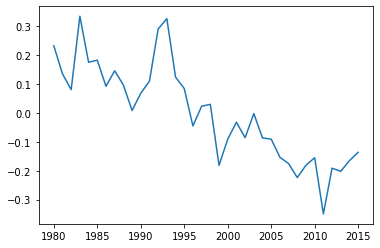

In [87]:
t =np.linspace(1980, 2015,(2015-1980+1))
eigvecs[0]
plt.plot(t, 0-eigvecs[0])

In [85]:
index = np.argsort(eigenvalues)[::-1]
eigvals = eigenvalues[index]
eigvecs = eigenvectors[index]


In [88]:
num_eval = np.arange(eigvals.shape[0])+1
cumulative_eval = np.cumsum(eigvals)

In [89]:
for i in range(eigvecs.shape[0]):
    print(np.linalg.norm(eigvecs[i]))

1.0
0.9999999999999999
1.0
0.9999999999999999
0.9999999999999999
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0000000000000002
0.9999999999999999
1.0
1.0
0.9999999999999998
1.0000000000000002
1.0
1.0
1.0
0.9999999999999999
1.0
1.0
1.0
0.9999999999999999
1.0
0.9999999999999999
1.0000000000000002
0.9999999999999999
1.0
0.9999999999999999
1.0000000000000002
1.0
0.9999999999999999
0.9999999999999998


C:\Users\tbui0\Anaconda3\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\Users\tbui0\Anaconda3\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


<Figure size 2160x1008 with 0 Axes>

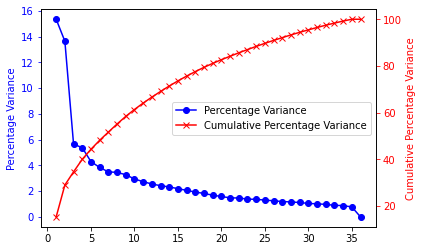

In [90]:
plt.figure(figsize=(30., 14.))
fig, ax = plt.subplots()

p1, = plt.plot(num_eval,(eigvals/cumulative_eval[-1])*100, 'b', marker = 'o',label = 'Percentage Variance')
ax.set_ylabel("Percentage Variance")
ax.yaxis.label.set_color('blue')
ax.tick_params('y', colors='b')

ax2 = ax.twinx()
p2, = plt.plot(num_eval,(cumulative_eval/cumulative_eval[-1])*100,'r', marker = 'x',label = 'Cumulative Percentage Variance')
ax2.tick_params('y', colors='r')
ax2.set_ylabel("Cumulative Percentage Variance")
ax2.yaxis.label.set_color('red')

plt.legend(handles=[p1,p2],loc='center right')

plt.show()


In [93]:
EOFS = []

for j in range(0,vweightedanom.shape[1]):
        EOFS.append(np.matmul(vweightedanom, eigvecs[j])/np.linalg.norm(np.matmul(NanlessAnom, eigvecs[j])))
EOF1 = np.array(EOFS).T

In [120]:
np.save('C:/Users/tbui0/OneDrive/Desktop/EOFs for all Months/January/January GeometricEOFs (5m).npy', EOF1)

In [94]:
for i in range(0,33):
    test1 = pd.DataFrame(EOF1[:,i])
    test2 = test1.dropna()
    test3 = test2.to_numpy()
    print(np.linalg.norm(test3))

0.9999999999999997
1.0000000000000002
0.9999999999999998
1.0
1.0
0.9999999999999996
1.0000000000000002
1.0000000000000007
1.0000000000000009
0.9999999999999997
0.9999999999999994
1.0000000000000002
0.9999999999999999
0.9999999999999996
1.0000000000000004
1.0000000000000004
1.0000000000000002
0.9999999999999993
1.0
0.9999999999999998
1.0
1.0000000000000009
0.9999999999999996
0.9999999999999997
1.0
1.0000000000000004
1.0000000000000002
0.9999999999999997
0.9999999999999998
0.9999999999999997
0.9999999999999999
0.9999999999999999
1.0000000000000009


In [95]:
#Physical EOFs
np.seterr(divide='ignore', invalid='ignore')
PhysicalEOFs = EOF1/(weightedA[0:air[0].size+360*418] * np.sqrt(thickness[0:air[0].size+360*418]) * np.sqrt(density[0:air[0].size+360*418]) * np.sqrt(heatCap[0:air[0].size+360*418]) * np.sqrt(gridSize[0:air[0].size+360*418]))

In [63]:
np.save('C:/Users/tbui0/OneDrive/Desktop/EOFs for all Months/January PhysicalEOFs.npy', PhysicalEOFs)

In [96]:
np.nanmax(PhysicalEOFs[:,0])

7.29474746139948e-05

In [97]:
np.nanmin(PhysicalEOFs[:,0])

-6.726794160613954e-05

In [8]:
import matplotlib.colors as colors
colors1 = plt.cm.seismic(np.linspace(0, 0.45, 500))
colors2 = plt.cm.autumn_r(np.linspace(0, 1, 500))

# combine them and build a new colormap
color = np.vstack((colors1, colors2))
mymap = colors.LinearSegmentedColormap.from_list('my_colormap', color)

In [25]:
eofs = np.reshape(PhysicalEOFs[0:-xxwater.size,0], (28,181,360))

In [9]:
PhysicalEOFs = np.load('January Physical EOFs.npy')

In [11]:
np.save('January Physical EOFs.npy', PhysicalEOFs)

In [28]:
EOFS = []
for i in range(28):
    EOFS.append(eofs[i].flatten())
len(EOFS)

28

In [30]:
EOFS = np.array(EOFS).T
EOFS.shape

(65160, 28)

In [11]:
def f(aw, mode, p):
    if aw == 1:
        ig=plt.figure(figsize=(20, 8) )

        # Miller projection:
        m=Basemap(projection='cyl',lat_ts=10,llcrnrlon=lons.min(), \
          urcrnrlon=lons.max(),llcrnrlat=lats.min(),urcrnrlat=lats.max(), \
          resolution='c')
       
        Z = 0-np.reshape(PhysicalEOFs[air[0].size:air[0].size+360*418,mode-1], (418,360))
        zmin = np.nanmin(Z)
        zmax = np.nanmax(Z)
        zlim = np.minimum(np.abs(zmin), zmax)
        surface = np.clip(Z, -zlim, zlim)        
        vmax = np.nanmax(surface)
        vmin = np.nanmin(surface)

        norm = colors.TwoSlopeNorm(vmin = vmin, vcenter=0.0, vmax = vmax)
        m.pcolormesh(xxwater,yywater,surface,norm = norm, shading='auto',cmap=mymap)
        m.colorbar(location='right')
        m.drawcoastlines()
        m.drawmapboundary()
        m.drawparallels(np.arange(-90.,90.,30.),labels=[1,0,0,0])
        m.drawmeridians(np.arange(-180.,180.,60.),labels=[0,0,0,1])

        #plt.contourf(xxwater,yywater, surface,1000, norm = norm,cmap= mymap)
        #plt.colorbar()
        plt.title('January Physical EOFs at  5m. Mode '+  str(mode), size = 18)
    else: 
        ig=plt.figure(figsize=(20, 8) )

        # Miller projection:
        m=Basemap(projection='cyl',lat_ts=10,llcrnrlon=lons.min(), \
          urcrnrlon=lons.max(),llcrnrlat=lats.min(),urcrnrlat=lats.max(), \
          resolution='c')

        x, y = m(*np.meshgrid(lons,lats))
        Z =0-np.reshape(PhysicalEOFs[181*360*p:181*360*(p+1),mode-1],(181,360))
        zmin = np.nanmin(Z)
        zmax = np.nanmax(Z)
        zlim = np.minimum(np.abs(zmin), zmax)
        surface = np.clip(Z, -zlim, zlim)        
        vmax = np.nanmax(surface)
        vmin = np.nanmin(surface)
        norm = colors.TwoSlopeNorm(vmin = vmin, vcenter=0.0, vmax = vmax)

        m.pcolormesh(x,y,surface,norm = norm, shading='auto',cmap=mymap)
        m.colorbar(location='right')
        m.drawcoastlines()
        m.drawmapboundary()
        m.drawparallels(np.arange(-90.,90.,30.),labels=[1,0,0,0])
        m.drawmeridians(np.arange(-180.,180.,60.),labels=[0,0,0,1])
        plt.title('January Air Physical EOFs at '+ str(levels[p]) + ' mbar. Mode ' + str(mode), size = 18 )
interactive(f, aw = (0,1), mode = (1,34), p = (0, levels.size-2))

interactive(children=(IntSlider(value=0, description='aw', max=1), IntSlider(value=17, description='mode', max…